In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


#### Data

In [9]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (Features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = X * weight + bias

In [12]:
print(f"X shape: {X.shape} \ny shape: {y.shape}")
print("X: \n",X[:10])
print("y: \n",y[:10])

X shape: torch.Size([50, 1]) 
y shape: torch.Size([50, 1])
X: 
 tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
y: 
 tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


##### Separar os dados em treino e teste

In [14]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [38]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")
    plt.scatter(test_data, test_labels, c='g', s=4, label="Test data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    plt.legend(prop={"size":14})

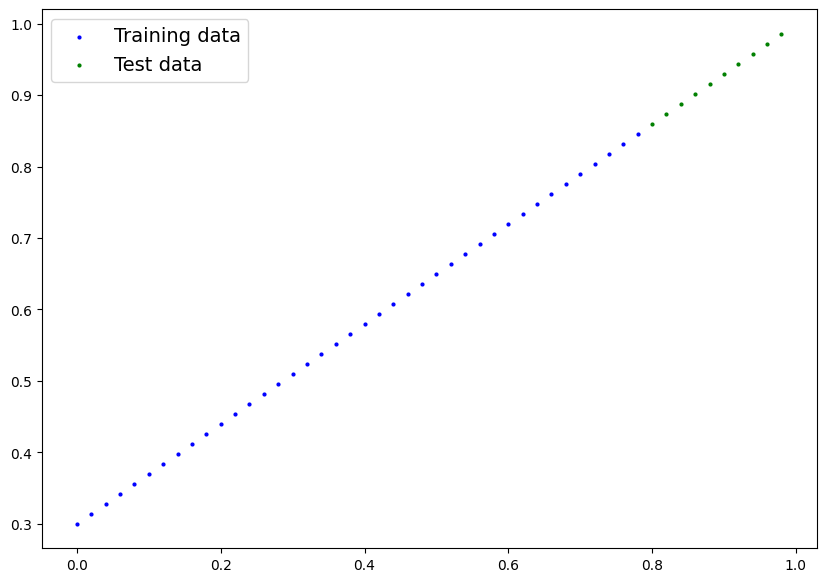

In [16]:
plot_predictions()

#### Construindo o PyTorch linear model

In [27]:
class LinearRegressionModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # Usando o nn.Linear para criar os parametros
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV1()
model_1, model_1.state_dict()

(LinearRegressionModelV1(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [28]:
# Checando o device do model
device_m = next(model_1.parameters()).device
print(device_m)
# Setando para o device que queremos
if device_m != device:
    model_1.to(device)
    print(next(model_1.parameters()).device)

cpu
cpu


#### Treinando o model

In [29]:
loss_fn = nn.L1Loss()
opt = torch.optim.SGD(params=model_1.parameters(),
                      lr=0.01)

In [35]:
torch.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # Setar o modelo para modo de treinamento
    model_1.train()
    
    # 1. Foward pass
    y_pred = model_1.forward(X_train)
    
    # 2. Calcular o loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Setar o gradiente do opt como zero
    opt.zero_grad()
    
    # 4. Backpropagation loss
    loss.backward()
    
    # 5. Step o opt
    opt.step()
    
    # Setar o modelo para modo de avaliação para teste (inference)
    model_1.eval() 
    
    with torch.inference_mode():
        test_pred = model_1(X_test)
        
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 100 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904


In [33]:
from pprint import (
    pprint,
)  # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html

print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")


The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


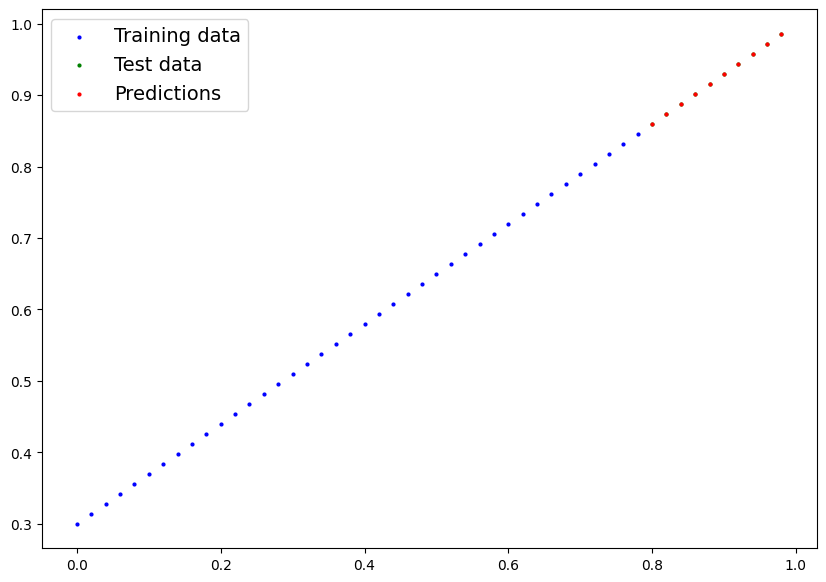

In [40]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)
plot_predictions(predictions=y_preds)

#### Salvar e carregar o modelo

In [46]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_lr_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Salvando o modelo para: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Salvando o modelo para: models\01_pytorch_lr_workflow_model_1.pth


In [47]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV1()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")


Loaded model:
LinearRegressionModelV1(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu
